# Contents
1.  Data Exploration
2.  Simple predictor as a baseline
3.  Linear regression
4.  Logistical regression


# Data Exploration and Cleaning

In [237]:
#import some packages we expect to use
import pandas as pd
from matplotlib import pyplot as pp
from __future__ import division

%pylab inline

# Read the data.  
data = pd.read_csv('input/train.csv')
print(data.head(10))

Populating the interactive namespace from numpy and matplotlib
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6

`%matplotlib` prevents importing * from pylab and numpy


Some observations: 
- We see there are many missing values in many columns.  We'll need to find which columns are missing values and then find a way to fix it so that we are still use the information.
- Many columns have non-numeric data.  These will have to be changed to numeric data.  
- We can ignore some of the features.  Without domain expertise, we do not know how to leverage some of the data -- we don't know what it means and implies.  We will ignore Cabin and Ticket information.  

In [238]:
pd.isnull(data).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [239]:
#1 We expect Age to be important.  We can replace the missing ages with the median age of men and women. 
medianAgeWomen = data.loc[data['Sex']=='female', 'Age'].median()
medianAgeMen = data.loc[data['Sex']=='male', 'Age'].median()
data.loc[data['Sex']=='female', 'Age'] = data.loc[data['Sex']=='female', 'Age'].fillna(medianAgeWomen)
data.loc[data['Sex']=='male', 'Age'] = data.loc[data['Sex']=='male', 'Age'].fillna(medianAgeMen)

#Change Sex and Embarked to numerical values
data.loc[data['Sex']=='male', 'Sex'] = 0
data.loc[data['Sex']=='female', 'Sex'] = 1

#replace missing Embarked value with 'S'
data['Embarked'] = data['Embarked'].fillna('S')
data.loc[data['Embarked'] == 'S', 'Embarked'] = 0
data.loc[data['Embarked'] == 'C', 'Embarked'] = 1
data.loc[data['Embarked'] == 'Q', 'Embarked'] = 2


# Baseline Predictor (Simple, Intuitive, First Pass)

Age and Sex seem to be the most intuitive features to correlate survival.  We will do a very quick exploration to see if there is something to our intuition. 

In [240]:
d= data.groupby('Sex').Survived.value_counts()
print d
d= data.groupby('Survived').Age.mean()
print d

Sex  Survived
0    0           468
     1           109
1    1           233
     0            81
Name: Survived, dtype: int64
Survived
0    30.193989
1    28.232953
Name: Age, dtype: float64


The mean age of the survivors isn't much different than the mean age of all the passengers.  However, women seem to have a much higher survival rate. We can use that as a first cut baseline predictor.  If woman, declare survived.  We can compute the accuracy of such a pedictor: 

In [241]:
survived = data['Sex']
accuracy_gender_based_predictor = sum(data['Survived'] == survived)/len(data['Sex']) 
print 'Accuracy of the gender based predictor: %f' %accuracy_gender_based_predictor

Accuracy of the gender based predictor: 0.786756


In [242]:
#read the test data
test_data = pd.read_csv('input/test.csv')
test_data.loc[test_data['Sex']=='female', 'Sex'] = 1
test_data.loc[test_data['Sex']=='male', 'Sex'] = 0

submit_gender_predictor = pd.DataFrame({'PassengerId': test_data['PassengerId'],
                                       'Survived':test_data['Sex']})
submit_gender_predictor.to_csv('gender_based_predictor.csv')

Submitting the results show accuracy of   

Let's see if we can do better.  We will try linear regression. 


# Linear  and Logistic Regression

In [243]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize the algorithm class
alg = LinearRegression()

# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(data.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (data[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = data["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(data[predictors].iloc[test,:])
    predictions.append(test_predictions)

Evaluate the accuracy of the linear model

In [244]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0


Note that this is really a logistic regression -- we are predicting binary class -- either survived or not survived. 
Also, python provides functions to do the exercise above much more simply: 

In [245]:
from sklearn import cross_validation, linear_model

# Initialize our algorithm
alg = linear_model.LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.
kf = cross_validation.KFold(data.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, data[predictors], data["Survived"], cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.79012345679


The accuracy from a logistic regression is about the same as our simple predictor.  We will make submission to check how the predictor performs on the test data. 

In [246]:
#Process the test data the same way as the training data: 

test_data.loc[test_data['Sex']==1, 'Age'] = test_data.loc[test_data['Sex']==1, 'Age'].fillna(medianAgeWomen)
test_data.loc[test_data['Sex']==0, 'Age'] = test_data.loc[test_data['Sex']==0, 'Age'].fillna(medianAgeMen)

#replace missing Embarked value with 'S'
test_data['Embarked'] = test_data['Embarked'].fillna('S')
test_data.loc[test_data['Embarked'] == 'S', 'Embarked'] = 0
test_data.loc[test_data['Embarked'] == 'C', 'Embarked'] = 1
test_data.loc[test_data['Embarked'] == 'Q', 'Embarked'] = 2

test_data['Fare'] = test_data['Fare'].fillna(0)

alg = linear_model.LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(data[predictors], data['Survived'])

# Make predictions using the test set.
predictions = alg.predict(test_data[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submit_logistic_regression_predictor = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': predictions
    })

submit_logistic_regression_predictor.to_csv('submit_logistic_regression_predictor.csv')

   Pclass Sex   Age  SibSp  Parch     Fare Embarked
0       3   0  34.5      0      0   7.8292        2
1       3   1  47.0      1      0   7.0000        0
2       2   0  62.0      0      0   9.6875        2
3       3   0  27.0      0      0   8.6625        0
4       3   1  22.0      1      1  12.2875        0


Submitting the results show accuracy of 

Next we will try a Random Forest classifier: 

In [247]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

#use default parameters for Random Forest classifier.
alg = RandomForestClassifier(random_state = 1)
kf = cross_validation.KFold(data.shape[0], n_folds = 3, random_state = 1)
scores = cross_validation.cross_val_score(alg, data[predictors], data['Survived'], cv=kf)
print (scores.mean())


0.786756453423


We'll do some feature engineering next to improve the accuracy. 

In [252]:
#generate Family size
data['FamilySize'] = data['SibSp'] + data['Parch']+1 #include self in the family. 

import re
#generate titles 
def extractTitle(name):
    if(name is not None):
        title = re.search(r'([A-Z][a-z]+)\.', name)
        if title:
            return title.group(1)
        return ""
    return ""
data['Title'] = data['Name'].apply(extractTitle)
data['Title'].value_counts()
title_code = {'Mr':1, 'Don': 1, 'Miss':2, 'Ms':2, 'Mlle':2, 'Mrs':3, 'Mme': 3, 'Master':4, 'Dr':5, 'Rev':6, 
              'Col':7, 'Major':7, 'Capt':7, 'Countess':8, 'Lady':8, 'Jonkheer':8, 'Sir':9}
data['Title_code'] = [title_code[x] for x in data['Title']]

# Collect the people in a family.  Use lastname + family size to identify. Then assign a numerical value to the family. 
data['Family'] =  [x.split(",")[0] for x in data['Name']]
data.loc[data['FamilySize'] == 1, 'Family'] = 'noFamily'
data['Family'] = data['Family'] + [str(x) for x in data['FamilySize']]
FamilyDic = dict(zip(data['Family'].unique(), range(len(data['Family'].unique()))))
data['Family'] = [FamilyDic[x] for x in data['Family']]


Now, let's see whether any of the features that we have generated are useful

([<matplotlib.axis.XTick at 0xe294198>,
 <a list of 10 Text xticklabel objects>)

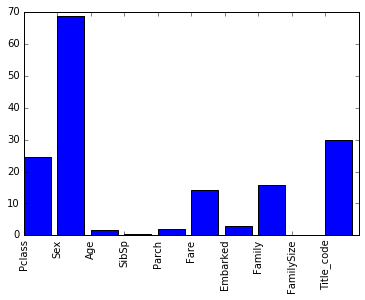

In [249]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

#we have added new features: 
predictor = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Family", "FamilySize", "Title_code"]
s = SelectKBest(f_classif, k = 5)
s.fit(data[predictor], data['Survived'])

scores = -np.log10(s.pvalues_)

pyplot.bar(range(len(predictor)), scores)
pyplot.xticks(range(len(predictor)), predictor, rotation='vertical')

Use the five highest values to generate a solution. 

In [250]:
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf= 4)
score = cross_validation.cross_val_score(alg, data[predictor], data['Survived'], cv = kf)
print(mean(score))

0.826038159371


Generate the same features for the test set and then prepare a submission. 

In [256]:
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']+1 #include self in the family. 

#generate titles 

test_data['Title'] = test_data['Name'].apply(extractTitle)

#use the same titlecode as before. 
test_data['Title_code'] = [title_code.get(x, -1) for x in test_data['Title']]

# Collect the people in a family.  Use lastname + family size to identify. Then assign a numerical value to the family. 
test_data['Family'] =  [x.split(",")[0] for x in test_data['Name']]
test_data.loc[test_data['FamilySize'] == 1, 'Family'] = 'noFamily'
test_data['Family'] = test_data['Family'] + [str(x) for x in test_data['FamilySize']]
test_data['Family'] = [FamilyDic.get(x, -1) for x in test_data['Family']]

In [260]:
alg.fit(data[predictor], data['Survived'])
prediction = alg.predict(test_data[predictor])
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 
                          'Survived' : prediction})
submission.to_csv('submit_random_forest.csv')

Our accuracy with this submission is: 

There are many more things to try with this dataset and I  hope to return to try them soon. 
1. What if we tried gradient boosting? 
2. What if we averaged the results from multiple classifiers, as in an ensemble? 
3. What if we used a vote from each classifier? 
